In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from sklearn.neighbors import NearestNeighbors

In [12]:
# resize the image
def down_to_10(img_name, img_path = '../data/lettuce_home/', result_path = '../data/lettuce_home/resized/'):
    img = cv2.imread(img_path + img_name)
    scale_percent = 10 # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    
    cv2.imwrite(result_path + img_name, resized)

In [2]:
def gen_plant_mask(inp_img):
  # generate a mask to figure out the plant region from an RGB image
  
  # green value greater than 30 in number
  # and greater than 2R and 2B
  
  hsv_img = cv2.cvtColor(inp_img,cv2.COLOR_BGR2HSV)
  mask = cv2.inRange(hsv_img, (36, 25, 25), (70, 255,255))
  #mask = np.logical_and(np.logical_and(np.greater(inp_img[:,:,1], green_val_threshold), 
  #                                     inp_img[:,:,1] >= green_mult_threshold*inp_img[:,:,0]
  #                                    ), 
  #                      inp_img[:,:,1] >= green_mult_threshold*inp_img[:,:,2])
  
  # open the mask
  #mask = cv2.morphologyEx(mask, cv2.MORPH_ERODE, cv2.getStructuringElement(cv2.MORPH_RECT,(5,5)))
  mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT,(5,5)))
  mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT,(15,15)))
  
  bool_mask = mask>0
  
  int_mask = np.zeros_like(mask, dtype=np.uint8)
  int_mask[bool_mask] = 255
  return int_mask
            

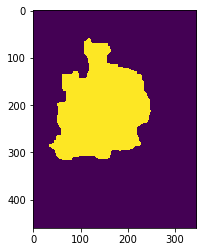

In [3]:
img = cv2.imread('../data/lettuce_home/img1.jpg')
mask = gen_plant_mask(img)

plt.imshow(mask)
plt.show()

In [ ]:
fig = plt.figure()
fig.add_subplot(2,2,1)
plt.imshow(img)
fig.add_subplot(2,2,2)
plt.imshow(img[:,:,0])
fig.add_subplot(2,2,3)
plt.imshow(img[:,:,1])
fig.add_subplot(2,2,4)
plt.imshow(img[:,:,2])
plt.show()


In [7]:
img = cv2.imread('../data/lettuce_home/img1.jpg')
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
sift = cv2.xfeatures2d.SIFT_create()
kp, des = sift.detectAndCompute(gray, gen_plant_mask(img))
img=cv2.drawKeypoints(gray,kp,img)
cv2.imwrite('../result/lettuce_home/sift/img1.jpg',img)

True

In [40]:
def get_neighbor_description(keypoints, descriptors, nWeight = 0.1):
  # extract point coordinates from keypoints
  coordinates = np.array([(x.pt) for x in keypoints], dtype=np.float32)
  
  # find 5 nearest neighbors
  nbrs = NearestNeighbors(n_neighbors=2).fit(coordinates)
  
  # get the distances and the indices of neighbors for each coordinate
  distances, indices = nbrs.kneighbors(coordinates)
  
  # drop the self-match
  distances_ = distances[:,1:]
  indices_ = indices[:,1:]
  
  # calculate the avg of the neighborhood descriptors
  avg_neighbor_des = np.average(descriptors[indices_,:], axis=1)
  
  # create a new descriptor by weighting
  #new_descriptors = (1-nWeight)*descriptors + nWeight * avg_neighbor_des
  
  # concat instead of averaging
  #print(descriptors.shape)
  new_descriptors = np.concatenate((descriptors, avg_neighbor_des*nWeight), axis=1)
  #print(new_descriptors.shape)
  
  return new_descriptors

In [22]:

print(keypoint_loc)

[[ 33.321545 286.7258  ]
 [ 46.296677 277.5986  ]
 [ 46.68601  299.5748  ]
 ...
 [242.03563  218.43362 ]
 [242.92778  201.85857 ]
 [242.92778  201.85857 ]]


In [31]:
distances, indices = nbrs.kneighbors(keypoint_loc)

In [51]:
print(distances.shape)
print(np.min(indices))

(677, 5)
676


In [41]:
des_exploded = des[indices_, :]
print(des_exploded.shape)

avg_neighbor_des = np.average(des_exploded, axis=1)
print(avg_neighbor_des.shape)

(677, 4, 128)
(677, 128)


In [42]:
def match_sift(img1, img2):
  # Initiate SIFT detector
  sift = cv2.xfeatures2d.SIFT_create()
  gray_im1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
  gray_im2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
  # find the keypoints and descriptors with SIFT
  kp1, des1 = sift.detectAndCompute(gray_im1, mask = gen_plant_mask(img1))
  kp2, des2 = sift.detectAndCompute(gray_im2, mask = gen_plant_mask(img2))
  
  des1 = get_neighbor_description(kp1, des1, nWeight=0.25)
  des2 = get_neighbor_description(kp2, des2, nWeight=0.25)
  
  # FLANN parameters
  FLANN_INDEX_KDTREE = 1
  index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
  search_params = dict(checks=50)   # or pass empty dictionary
  
  flann = cv2.FlannBasedMatcher(index_params,search_params)
  matches = flann.knnMatch(des1,des2,k=2)
  
  # Need to draw only good matches, so create a mask
  matchesMask = [[0,0] for i in range(len(matches))]
  # ratio test as per Lowe's paper
  for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:#0.7
      matchesMask[i]=[1,0]
      
  draw_params = dict(matchColor = (0,255,0),
                     singlePointColor = (255,0,0),
                     matchesMask = matchesMask,
                     flags = cv2.DrawMatchesFlags_DEFAULT)
  
  
  # cv.drawMatchesKnn expects list of lists as matches.
  img3 = cv2.drawMatchesKnn(gray_im1,kp1,gray_im2,kp2,matches,None,**draw_params)
  
  return img3

In [17]:
def load_image(imName, path = '../data/lettuce_home/'):
    img = cv2.imread(path + imName)
    
    return img

In [43]:
num_images = 6

for i in range(1, num_images+1):
  for j in range(i+1, num_images+1):
      im1 = load_image('img{}.jpg'.format(i))
      im2 = load_image('img{}.jpg'.format(j))
      
      match_im = match_sift(im1, im2)
      
      cv2.imwrite('../result/lettuce_home/sift_matching_custom/{}_{}.jpg'.format(i,j), match_im)

      #plt.imshow(match_2_3),plt.show()